ISyE 4803 - Foundations of Modern Data Science Proposal/Final Report

Team Member Names: Augusto Chang and Juan David Moutran

Project Title: Beyond Demographics in Customer Churn Prediction

proposal: https://docs.google.com/document/d/1x6xNZBLnB95Lbz9ouelVX070AeIiLW-mUN_NFmh92kE/edit


report: https://docs.google.com/document/d/1CaududpZ9egvmxa-OadnHfOXlNHoZvzNTNGCqJNzl7Y/edit

Sections

(1) Executing the prediction pipeline with non-demographic data only (even here, explain if you will use test error or confidence to assess model, what models will you use)

(2) Executing pipeline with all predictors including demographic data

(3) Inferring demographic data from non-demographic data



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error


## Load Data + Preprocessing

In [ ]:
drive.mount('/content/drive')

print(os.getcwd())
df = pd.read_csv('/content/drive/MyDrive/train.csv')

print(df.shape)
print(df.columns)

Mounted at /content/drive
/content
(165034, 14)
Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [ ]:
# mapping gender: Male=1, Female=0
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# mapping geography: France=1, Spain=2, Germany=3
df['Geography'] = df['Geography'].map({'France': 1, 'Spain': 2, 'Germany': 3})

print(df[['Gender', 'Geography']].head(10))

   Gender  Geography
0       1          1
1       1          1
2       1          1
3       1          1
4       1          2
5       1          3
6       0          1
7       1          2
8       1          1
9       1          3


In [ ]:
df['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [ ]:
X = df.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1) # feature matrix
y = df['Exited'] # target value

# to play around, using just 10% data
_,X_small, _,y_small = train_test_split(X, y, test_size=0.1, random_state=42)

print(X.shape, y.shape)
print(X_small.shape, y_small.shape)


(165034, 10) (165034,)
(16504, 10) (16504,)


In [ ]:
# 80-20 train test split
#X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

# standarizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# feature names
feature_names = X_train.columns.tolist()

(132027, 10)
(33007, 10)


In [ ]:
print(X.shape)
print(X.columns)
X_non_demo = X.drop(['Geography', 'Gender', 'Age', 'Tenure'], axis=1) # feature matrix
print(X_non_demo.shape)
print(X_non_demo.columns)

# to play around, using just 10% data
#_,X_non_demo_small, _,_ = train_test_split(X_non_demo, y, test_size=0.1, random_state=42)

# 80-20 train test split
#X_non_demo_train, X_non_demo_test, y_non_demo_train, y_non_demo_test = train_test_split(X_non_demo_small, y_small, test_size=0.2, random_state=42)
X_non_demo_train, X_non_demo_test, y_non_demo_train, y_non_demo_test = train_test_split(X_non_demo, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

# standarizing features
scaler = StandardScaler()
X_non_demo_train_scaled = scaler.fit_transform(X_non_demo_train)
X_non_demo_test_scaled = scaler.transform(X_non_demo_test)
X_non_demo_train_scaled = pd.DataFrame(X_non_demo_train_scaled, columns=X_non_demo_train.columns)
X_non_demo_test_scaled = pd.DataFrame(X_non_demo_test_scaled, columns=X_non_demo_train.columns)

print(X_non_demo_train_scaled.columns)
# feature names
feature_names = X_non_demo_train.columns.tolist()

(165034, 10)
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')
(165034, 6)
Index(['CreditScore', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')
(132027, 10)
(33007, 10)
Index(['CreditScore', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


## Exploratory Data Anlysis - PCA

In [ ]:
def get_feature_variance(pca, feature_names):
    return dict(zip(feature_names, np.round(pca.explained_variance_ratio_, 3)))

n_components_list = [2, 3, 4, 5]  # number of components
pca_dict = {}

# Fitting PCA for each number of components
for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    pca_dict[n_components] = pca

# Now iterating through the pca_dict to get and print the PCA features and explained variance
for components, pca in pca_dict.items():
    feature_variance = get_feature_variance(pca, feature_names)

    print(f"\nPCA with {components} components")
    print("Explained variance for each feature:", feature_variance)
    print("Total explained variance:", np.round(np.sum(pca.explained_variance_ratio_), 3))



PCA with 2 components
Explained variance for each feature: {'CreditScore': 0.168, 'Balance': 0.106}
Total explained variance: 0.274

PCA with 3 components
Explained variance for each feature: {'CreditScore': 0.168, 'Balance': 0.106, 'NumOfProducts': 0.103}
Total explained variance: 0.377

PCA with 4 components
Explained variance for each feature: {'CreditScore': 0.168, 'Balance': 0.106, 'NumOfProducts': 0.103, 'HasCrCard': 0.1}
Total explained variance: 0.477

PCA with 5 components
Explained variance for each feature: {'CreditScore': 0.168, 'Balance': 0.106, 'NumOfProducts': 0.103, 'HasCrCard': 0.1, 'IsActiveMember': 0.1}
Total explained variance: 0.577


(165034,)


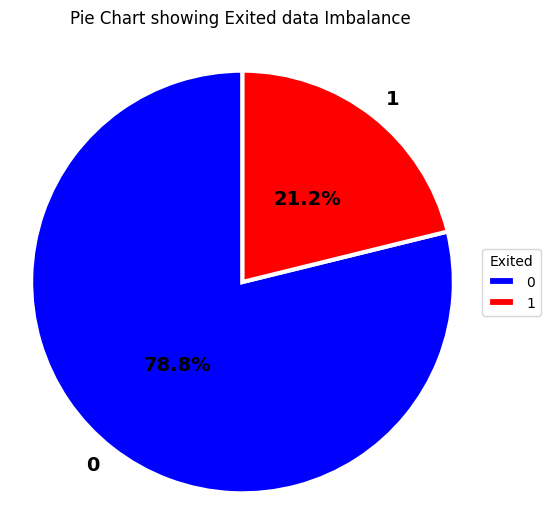

In [ ]:
print(y.shape)

unique, counts = np.unique(y, return_counts=True)

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=unique, colors=['blue', 'red'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(linewidth=3, edgecolor='white'), pctdistance=0.5, textprops={'fontsize': 14, 'fontweight': 'bold'})
plt.axis('equal')
plt.title('Pie Chart showing Exited data Imbalance ', pad=20)
plt.legend(title='Exited', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

(165034, 10)


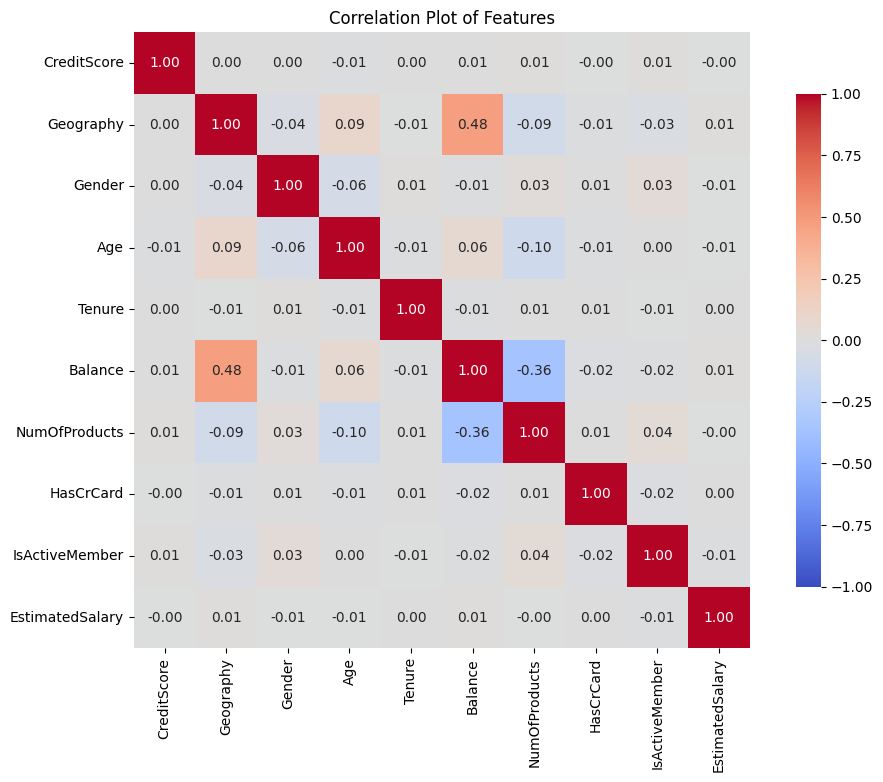

In [ ]:
print(X.shape)

corr = X.corr() #correlation matrix

# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Plot of Features')
plt.show()

# Analysis

### gridsearch tunning function

In [ ]:
def train(param_grid, estimator, X_train, X_test, y_train, y_test):
    '''
    function to perform grid search and find best hyper paramaters through 5 fold cross validation

    '''

    # grid search cv
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_score = accuracy_score(y_train_pred, y_train)
    test_score = accuracy_score(y_test_pred, y_test)

    print(f"Train accuracy score: {train_score}")
    print(f"Test accuracy score: {test_score}")
    print("Best Parameters", best_params)

    return grid_search, train_score, test_score

## (1) Executing the prediction pipeline with non-demographic data only

### Logistic Regression

In [ ]:
#parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [100]
}

#estimator
log_reg = LogisticRegression(random_state=42)

#grid search
grid_search, train_score, test_score = train(param_grid, log_reg, X_non_demo_train_scaled, X_non_demo_test_scaled, y_non_demo_train, y_non_demo_test)

Train accuracy score: 0.7881796905178486
Test accuracy score: 0.7892871209137455
Best Parameters {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
#print(grid_search.best_params_)

# Define the logistic regression model with the best parameters
log_reg = LogisticRegression(C=0.1, penalty='l1', solver='saga', max_iter=100, random_state=42)

log_reg.fit(X_non_demo_train_scaled, y_train)

# predictions
y_train_pred = log_reg.predict(X_non_demo_train_scaled)
y_test_pred = log_reg.predict(X_non_demo_test_scaled)

# accuracy
train_score = accuracy_score(y_train_pred, y_train)
test_score = accuracy_score(y_test_pred, y_test)

print(f"Logistic Regression train accuracy score: {train_score}")
print(f"Logistic Regression test accuracy score: {test_score}")

coefficients = log_reg.coef_[0]
feature_names = X_non_demo_train_scaled.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# logistic regression equation
intercept = log_reg.intercept_[0]
equation = " = {:.2f} + ".format(intercept) + " + ".join([ "{:.3f} * {}".format(coef, name) for coef, name in zip(coefficients, feature_names)])
print("Logistic Regression Equation:")
print(equation)

Logistic Regression train accuracy score: 0.7879827611018958
Logistic Regression test accuracy score: 0.7888629684612355
Logistic Regression Equation:
 = -1.50 + -0.057 * CreditScore + 0.143 * Balance + -0.514 * NumOfProducts + -0.064 * HasCrCard + -0.543 * IsActiveMember + 0.038 * EstimatedSalary


### Neural Network

Epoch 1/50
10563/10563 [==============================] - 68s 6ms/step - loss: 0.4377 - accuracy: 0.7963 - val_loss: 0.4019 - val_accuracy: 0.8082
Epoch 2/50
10563/10563 [==============================] - 77s 7ms/step - loss: 0.4124 - accuracy: 0.8060 - val_loss: 0.4013 - val_accuracy: 0.8113
Epoch 3/50
10563/10563 [==============================] - 41s 4ms/step - loss: 0.4109 - accuracy: 0.8061 - val_loss: 0.4026 - val_accuracy: 0.8033
Epoch 4/50
10563/10563 [==============================] - 36s 3ms/step - loss: 0.4100 - accuracy: 0.8061 - val_loss: 0.3997 - val_accuracy: 0.8125
Epoch 5/50
10563/10563 [==============================] - 39s 4ms/step - loss: 0.4101 - accuracy: 0.8070 - val_loss: 0.3991 - val_accuracy: 0.8122
Epoch 6/50
10563/10563 [==============================] - 35s 3ms/step - loss: 0.4092 - accuracy: 0.8063 - val_loss: 0.4008 - val_accuracy: 0.8045
Epoch 7/50
10563/10563 [==============================] - 39s 4ms/step - loss: 0.4094 - accuracy: 0.8072 - val_loss: 0

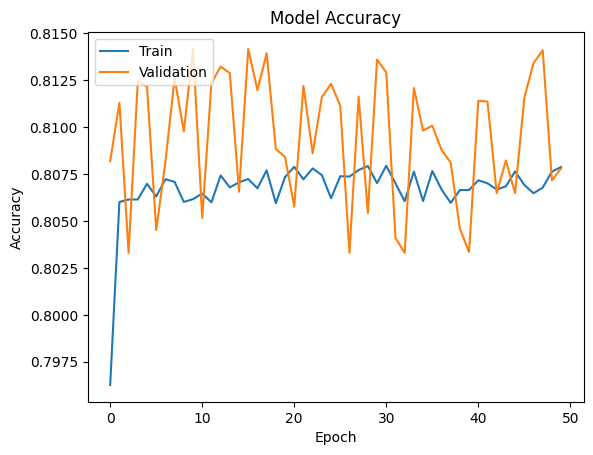

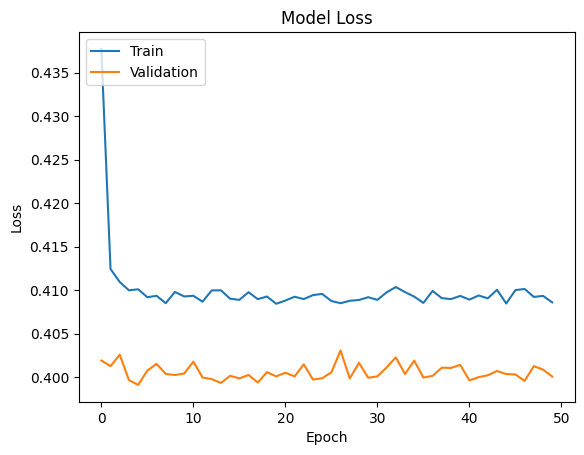

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam



# Neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X_non_demo_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_non_demo_train_scaled, y_non_demo_train, epochs=50, batch_size=10, validation_split=0.2, verbose=1)

# Evaluate the model
scores = model.evaluate(X_non_demo_test_scaled, y_non_demo_test, verbose=1)
print(f"Accuracy: {scores[1]*100}")

predictions = model.predict(X_non_demo_test_scaled)
predictions = (predictions > 0.5).astype(int)

# Visualize training process
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### XGBoost

In [ ]:
#parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3]
}

#estimator
xgb_model = xgb.XGBClassifier(random_state=42)

#grid search
grid_search, train_score, test_score = train(param_grid, xgb_model, X_non_demo_train_scaled, X_non_demo_test_scaled, y_non_demo_train, y_non_demo_test)

Train accuracy score: 0.8143637286312648
Test accuracy score: 0.8126155058017996
Best Parameters {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
           Feature  Importance
2    NumOfProducts    0.694626
4   IsActiveMember    0.224324
1          Balance    0.056823
3        HasCrCard    0.011074
0      CreditScore    0.007299
5  EstimatedSalary    0.005854


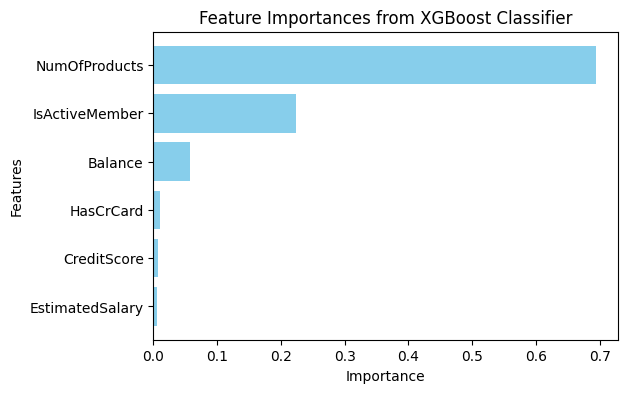

In [ ]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

feature_names = X_non_demo_train_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances })
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

# plot importances
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from XGBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

### Random Forest

In [ ]:
#parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
}

#estimator
rf_model = RandomForestClassifier(random_state=42)

#grid search
grid_search, train_score, test_score = train(param_grid, rf_model, X_non_demo_train_scaled, X_non_demo_test_scaled, y_non_demo_train, y_non_demo_test)

Train accuracy score: 0.8549572066954481
Test accuracy score: 0.810057558315662
Best Parameters {'max_depth': 10, 'n_estimators': 200}


Best Parameters: {'max_depth': 10, 'n_estimators': 200}
           Feature  Importance
2    NumOfProducts    0.433644
5  EstimatedSalary    0.158151
1          Balance    0.152668
0      CreditScore    0.133343
4   IsActiveMember    0.109970
3        HasCrCard    0.012224


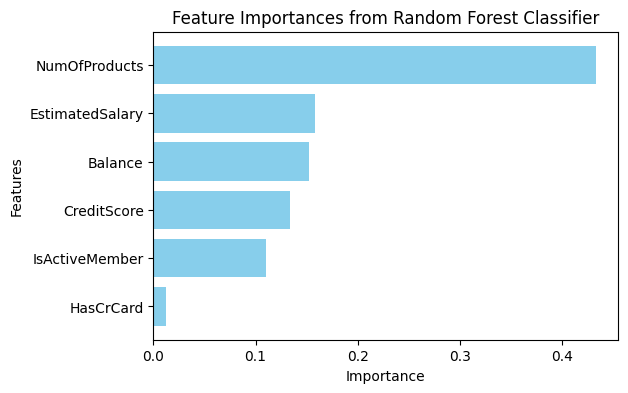

In [ ]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances })
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

# plot importances
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

## (2) Executing pipeline with all predictors including demographic data

### Logistic Regression

In [ ]:
#parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [100]
}

#estimator
log_reg = LogisticRegression(random_state=42)

#grid search
grid_search, train_score, test_score = train(param_grid, log_reg, X_train_scaled, X_test_scaled, y_train, y_test)


Train accuracy score: 0.83428008785882
Test accuracy score: 0.8345955770978492
Best Parameters {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


hyperparameter tunning GridSearchCV for logistic regression results

[0.78974476 0.81292121 0.82875108 0.83147752 0.83375007 0.83337126
 0.83367429 0.83344707 0.83344707 0.83344707]
Best Parameters {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


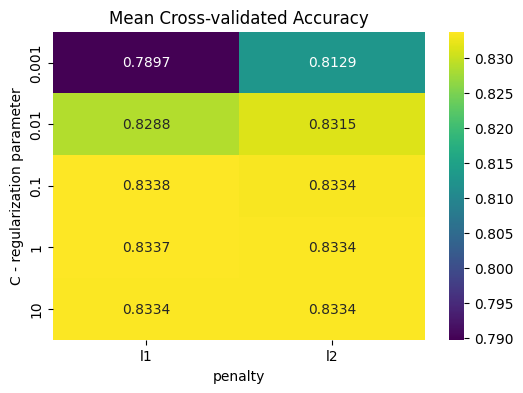

In [ ]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
print(mean_test_scores)
mean_test_scores = mean_test_scores.reshape(len(param_grid['C']), len(param_grid['penalty']), len(param_grid['solver']), len(param_grid['max_iter']))

#best parameters
print("Best Parameters", grid_search.best_params_)

#plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(mean_test_scores.mean(axis=(2, 3)), annot=True, fmt='.4f', cmap='viridis', xticklabels=param_grid['penalty'], yticklabels=param_grid['C'])
plt.xlabel('penalty')
plt.ylabel('C - regularization parameter')
plt.title('Mean Cross-validated Accuracy')
plt.show()

In [ ]:
#print(grid_search.best_params_)

# Define the logistic regression model with the best parameters
log_reg = LogisticRegression(C=0.1, penalty='l1', solver='saga', max_iter=100, random_state=42)

log_reg.fit(X_train_scaled, y_train)

# predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# accuracy
train_score = accuracy_score(y_train_pred, y_train)
test_score = accuracy_score(y_test_pred, y_test)

print(f"Logistic Regression train accuracy score: {train_score}")
print(f"Logistic Regression test accuracy score: {test_score}")

coefficients = log_reg.coef_[0]
feature_names = X_train_scaled.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# logistic regression equation
intercept = log_reg.intercept_[0]
equation = " = {:.2f} + ".format(intercept) + " + ".join([ "{:.3f} * {}".format(coef, name) for coef, name in zip(coefficients, feature_names)])
print("Logistic Regression Equation:")
print(equation)

Logistic Regression train accuracy score: 0.83428008785882
Logistic Regression test accuracy score: 0.8345955770978492
Logistic Regression Equation:
 = -1.76 + -0.045 * CreditScore + 0.395 * Geography + -0.339 * Gender + 0.839 * Age + -0.016 * Tenure + -0.022 * Balance + -0.475 * NumOfProducts + -0.089 * HasCrCard + -0.604 * IsActiveMember + 0.058 * EstimatedSalary


### Neural Network

Epoch 1/50
10563/10563 [==============================] - 33s 3ms/step - loss: 0.3843 - accuracy: 0.8374 - val_loss: 0.3401 - val_accuracy: 0.8557
Epoch 2/50
10563/10563 [==============================] - 28s 3ms/step - loss: 0.3546 - accuracy: 0.8521 - val_loss: 0.3340 - val_accuracy: 0.8604
Epoch 3/50
10563/10563 [==============================] - 30s 3ms/step - loss: 0.3510 - accuracy: 0.8532 - val_loss: 0.3305 - val_accuracy: 0.8622
Epoch 4/50
10563/10563 [==============================] - 28s 3ms/step - loss: 0.3494 - accuracy: 0.8539 - val_loss: 0.3289 - val_accuracy: 0.8621
Epoch 5/50
10563/10563 [==============================] - 30s 3ms/step - loss: 0.3483 - accuracy: 0.8541 - val_loss: 0.3288 - val_accuracy: 0.8625
Epoch 6/50
10563/10563 [==============================] - 31s 3ms/step - loss: 0.3479 - accuracy: 0.8543 - val_loss: 0.3285 - val_accuracy: 0.8623
Epoch 7/50
10563/10563 [==============================] - 50s 5ms/step - loss: 0.3464 - accuracy: 0.8555 - val_loss: 0

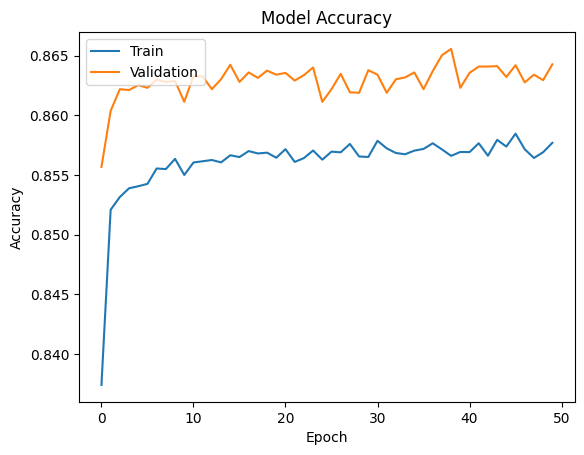

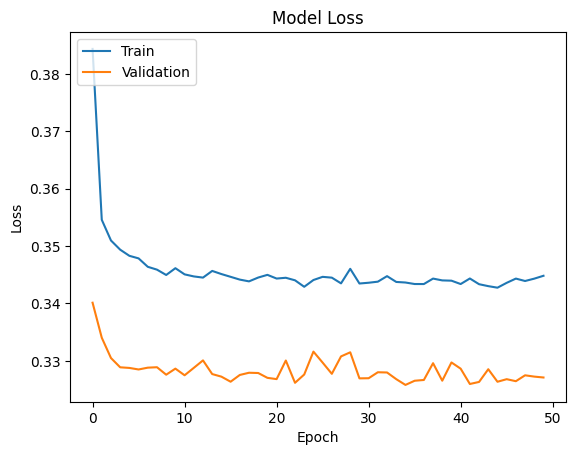

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, validation_split=0.2, verbose=1)

# Evaluate the model
scores = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Accuracy: {scores[1]*100}")

predictions = model.predict(X_test_scaled)
predictions = (predictions > 0.5).astype(int)

# Visualize training process
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### XGBoost

In [ ]:
#parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

#estimator
xgb_model = xgb.XGBClassifier(random_state=42)

#grid search
grid_search, train_score, test_score = train(param_grid, xgb_model, X_train_scaled, X_test_scaled, y_train, y_test )

Best Parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


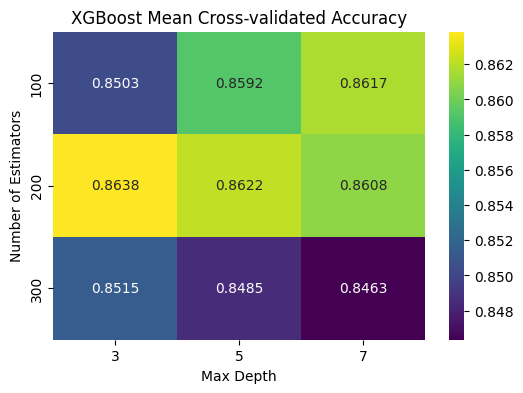

In [ ]:
# extracting results
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_test_scores = mean_test_scores.reshape(len(param_grid['n_estimators']), len(param_grid['learning_rate']), len(param_grid['max_depth']))

#best parameters
print("Best Parameters", grid_search.best_params_)

# Calculate mean across axis 3 (last axis) and plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(np.mean(mean_test_scores, axis=1), annot=True, fmt=".4f", cmap='viridis', xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'])
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.title('XGBoost Mean Cross-validated Accuracy')
plt.show()





Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
           Feature  Importance
6    NumOfProducts    0.382689
3              Age    0.216432
8   IsActiveMember    0.120579
2           Gender    0.070129
1        Geography    0.066476
5          Balance    0.050273
7        HasCrCard    0.026402
9  EstimatedSalary    0.022981
0      CreditScore    0.022545
4           Tenure    0.021494


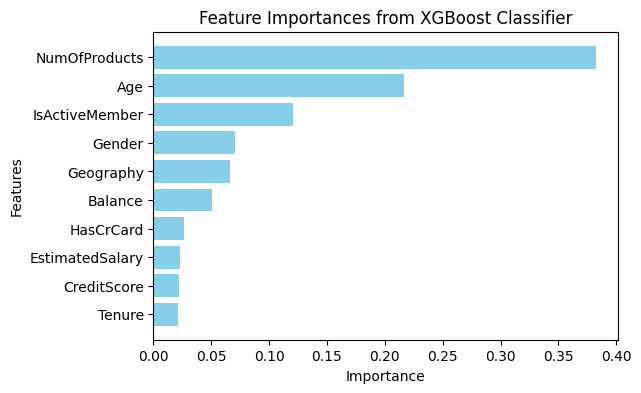

In [ ]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances })
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

# plot importances
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from XGBoost Classifier')
plt.gca().invert_yaxis()
plt.show()

### Random Forest

In [ ]:
#parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
}

#estimator
rf_model = RandomForestClassifier(random_state=42)

#grid search
grid_search, train_score, test_score = train(param_grid, rf_model, X_train_scaled, X_test_scaled, y_train, y_test )

Train accuracy score: 0.9073695372263879
Test accuracy score: 0.867009996970615
Best Parameters {'max_depth': 10, 'n_estimators': 200}


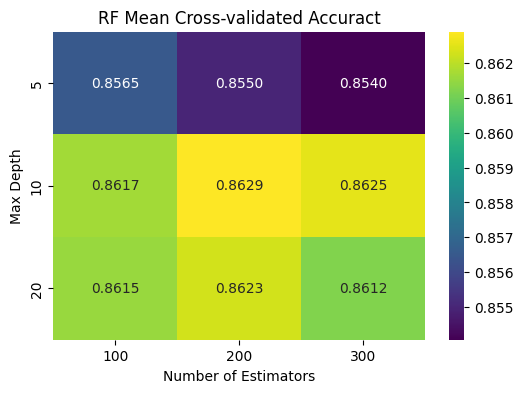

In [ ]:
# extracting results
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_test_scores = mean_test_scores.reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']))

# plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(mean_test_scores, annot=True, fmt=".4f", cmap='viridis', xticklabels=param_grid['n_estimators'], yticklabels=param_grid['max_depth'])
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.title('RF Mean Cross-validated Accuracy')
plt.show()

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
           Feature  Importance
3              Age    0.309196
6    NumOfProducts    0.236486
5          Balance    0.086043
9  EstimatedSalary    0.080092
0      CreditScore    0.075844
8   IsActiveMember    0.074108
1        Geography    0.055953
4           Tenure    0.040346
2           Gender    0.030738
7        HasCrCard    0.011194


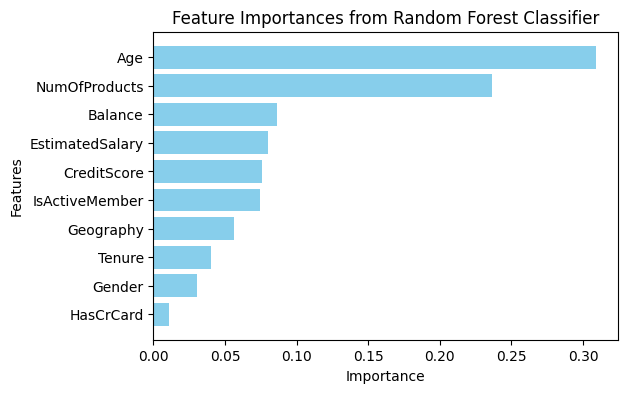

In [ ]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

feature_names = X_train_scaled.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances })
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

# plot importances
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

## (3) Inferring demographic data from non-demographic data

find age/gender from non demographic data + churn

GENDER


Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.53      0.48     14335
           1       0.58      0.50      0.54     18672

    accuracy                           0.51     33007
   macro avg       0.52      0.52      0.51     33007
weighted avg       0.52      0.51      0.52     33007

Accuracy Score: 0.513890992819705
Cross-Validation Accuracy Scores: [0.51499659 0.5068545  0.51145616 0.51331187 0.513274  ]
Mean CV Accuracy: 0.5119786263882261
ROC AUC: 0.5244270036155896


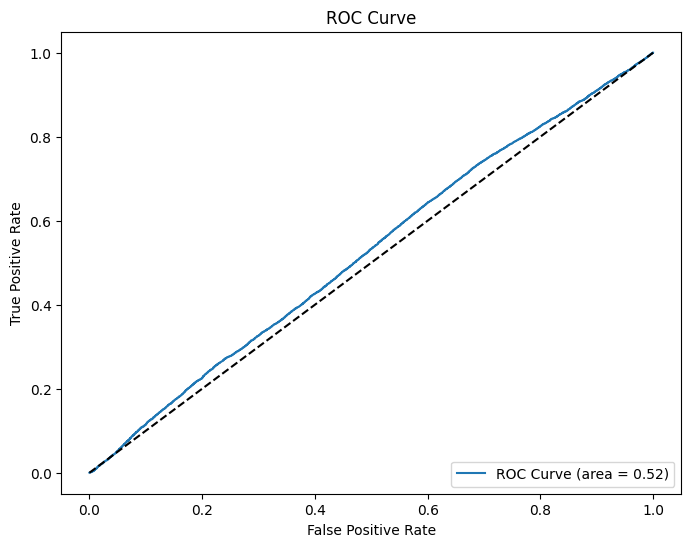

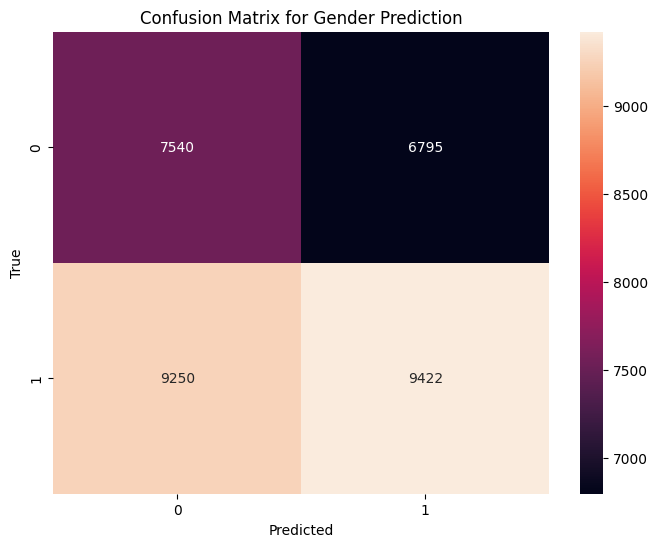

           Feature  Coefficient
4   IsActiveMember     0.066629
2    NumOfProducts     0.045065
3        HasCrCard     0.011097
0      CreditScore     0.003938
5  EstimatedSalary    -0.013101
1          Balance    -0.014675


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Extracting Gender data for training and testing
y_gender_train = X_train['Gender']
y_gender_test = X_test['Gender']
# Adjusting the Logistic Regression model to handle class weight
gender_model = LogisticRegression(random_state=42, class_weight='balanced')

# Train the model using the non-demographic scaled training data and gender labels
gender_model.fit(X_non_demo_train_scaled, y_gender_train)

# Predict Gender using the non-demographic scaled test data
y_gender_pred = gender_model.predict(X_non_demo_test_scaled)

# Adjust threshold for prediction based on the predicted probabilities
y_probs = gender_model.predict_proba(X_non_demo_test_scaled)[:, 1]
threshold = 0.50  # This might need adjustment based on the ROC curve analysis
y_gender_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate the model using classification report and accuracy
print("Classification Report:\n", classification_report(y_gender_test, y_gender_pred_adjusted, zero_division=0))
print("Accuracy Score:", accuracy_score(y_gender_test, y_gender_pred_adjusted))

# Cross-Validation with stratification
cv_scores = cross_val_score(gender_model, X_non_demo_train_scaled, y_gender_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Calculate AUC
roc_auc = roc_auc_score(y_gender_test, y_probs)
print(f"ROC AUC: {roc_auc}")

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_gender_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_gender_test, y_gender_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gender Prediction')
plt.show()

# Getting coefficients from the logistic regression model
coefficients = gender_model.coef_[0]
features = X_non_demo_train_scaled.columns
importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
importance_df.sort_values(by='Coefficient', ascending=False, inplace=True)
print(importance_df)


AGE


In [ ]:

y_age_train = X_train['Age']
y_age_test = X_test['Age']

# Define the regression model
age_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
age_model.fit(X_non_demo_train_scaled, y_age_train)

# Make predictions
y_age_pred = age_model.predict(X_non_demo_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_age_test, y_age_pred))
print(f"Root Mean Squared Error for Age Prediction: {rmse}")


Root Mean Squared Error for Age Prediction: 9.075297803019913


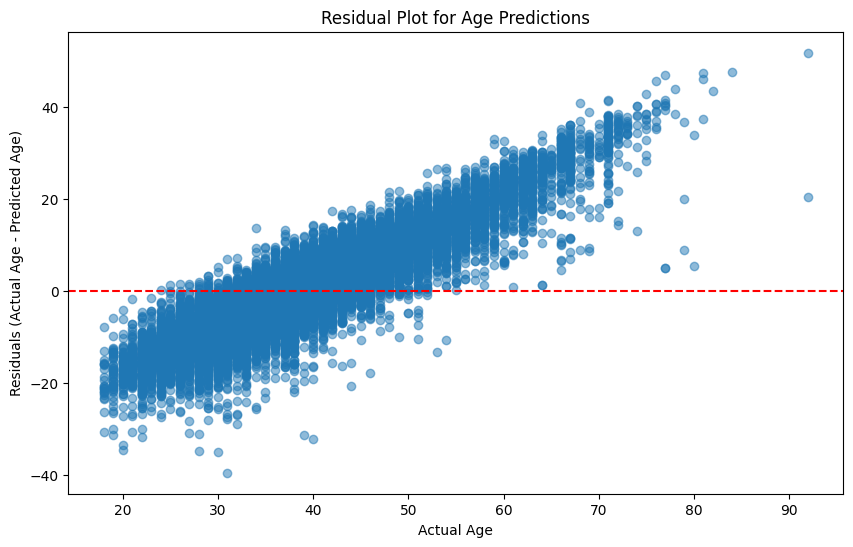

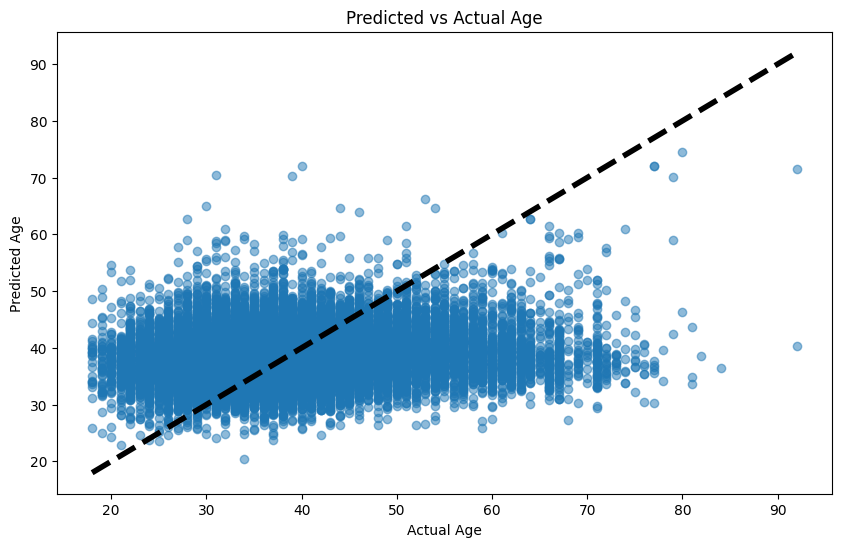

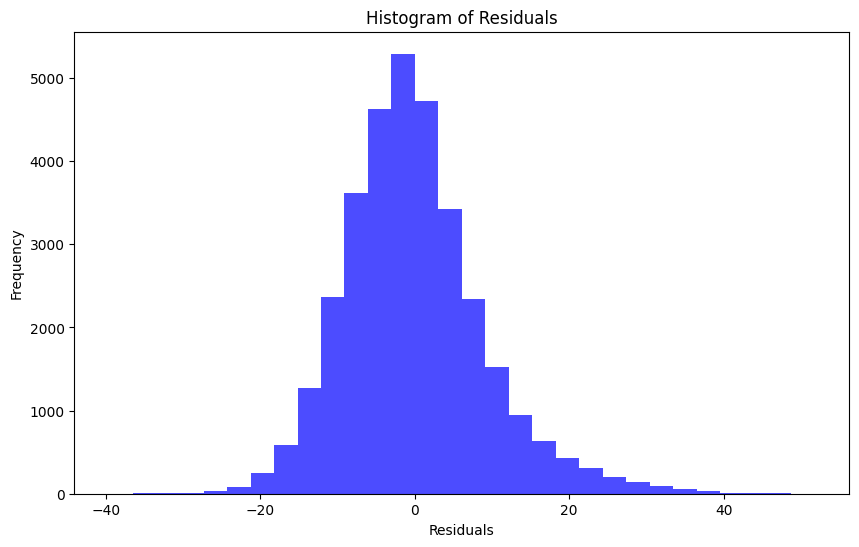

In [ ]:
import matplotlib.pyplot as plt

# Plotting the residuals
residuals = y_age_test - y_age_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_age_test, residuals, alpha=0.5)
plt.title('Residual Plot for Age Predictions')
plt.xlabel('Actual Age')
plt.ylabel('Residuals (Actual Age - Predicted Age)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Plotting predicted vs actual age
plt.figure(figsize=(10, 6))
plt.scatter(y_age_test, y_age_pred, alpha=0.5)
plt.plot([y_age_test.min(), y_age_test.max()], [y_age_test.min(), y_age_test.max()], 'k--', lw=4)
plt.title('Predicted vs Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

# Histogram of residuals
residuals = y_age_test - y_age_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Define the age bins
bins = np.arange(10, 100, 10)

y_age_test = pd.DataFrame({
    'Actual Age': X_test['Age'],  #
    'Predicted Age': y_age_pred
})

# Assign each age to a bin
y_age_test['Age Group'] = pd.cut(y_age_test['Actual Age'], bins, right=False)

# Calculate RMSE for each age group
grouped = y_age_test.groupby('Age Group')
rmse_by_group = {}
for group, sub_df in grouped:
    rmse = np.sqrt(mean_squared_error(sub_df['Actual Age'], sub_df['Predicted Age']))
    rmse_by_group[group] = rmse

print(rmse_by_group)
print(y_age_test['Age Group'].value_counts())


{Interval(10, 20, closed='left'): 19.372460523172382, Interval(20, 30, closed='left'): 11.811876769675802, Interval(30, 40, closed='left'): 5.563857424687776, Interval(40, 50, closed='left'): 6.476973597706942, Interval(50, 60, closed='left'): 14.793951183238898, Interval(60, 70, closed='left'): 24.29514598378231, Interval(70, 80, closed='left'): 33.27414605969375, Interval(80, 90, closed='left'): 39.778641877308665}
Age Group
[30, 40)    16285
[40, 50)     8640
[20, 30)     4605
[50, 60)     2467
[60, 70)      780
[70, 80)      153
[10, 20)       68
[80, 90)        7
Name: count, dtype: int64


           Feature  Importance
5  EstimatedSalary    0.465081
0      CreditScore    0.292607
1          Balance    0.169507
2    NumOfProducts    0.032669
3        HasCrCard    0.032253
4   IsActiveMember    0.007883


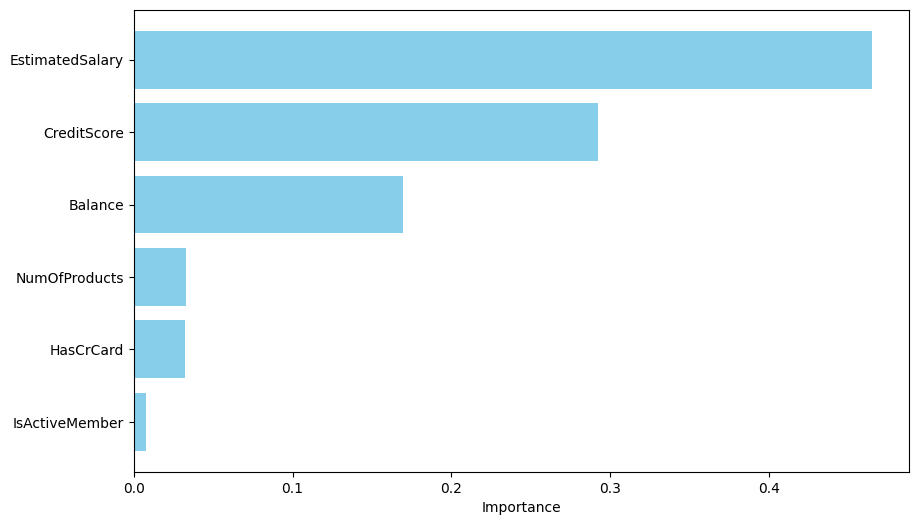

In [ ]:
importances = age_model.feature_importances_
feature_names = X_non_demo_train.columns.tolist()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


<ipython-input-22-1ba123286204>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'Residuals'] = filtered_data['Actual Age'] - filtered_data['Predicted Age']


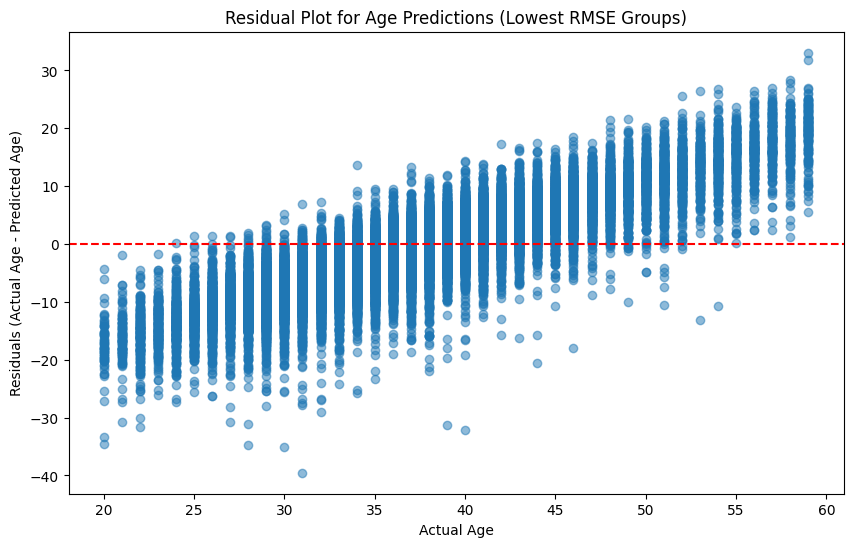

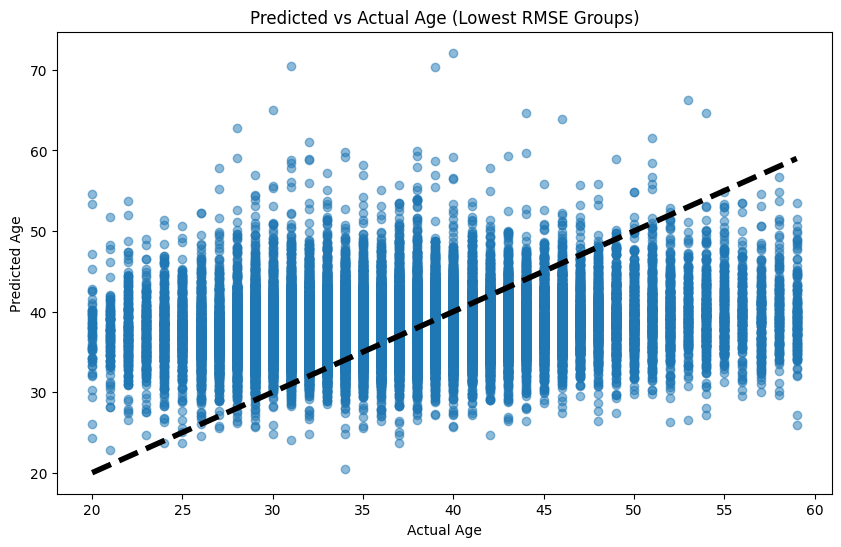

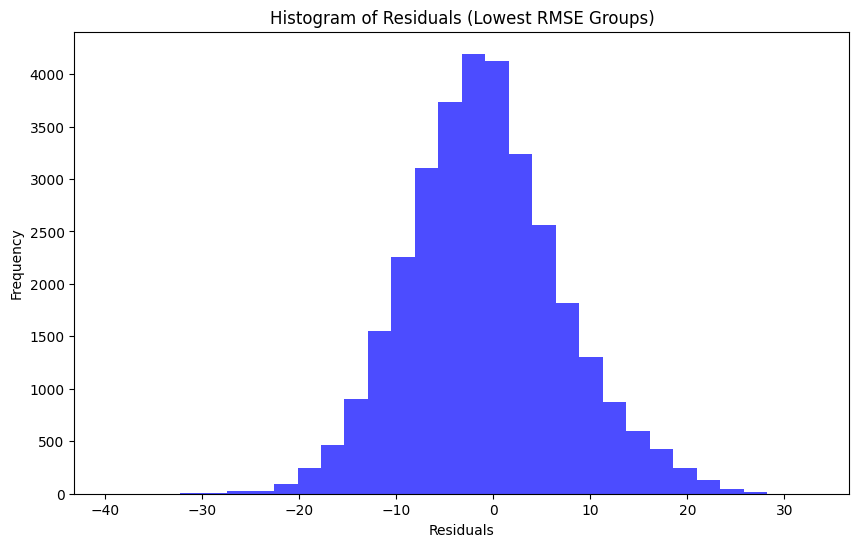

In [ ]:
sorted_rmse = sorted(rmse_by_group.items(), key=lambda x: x[1])

# Get the age groups with the lowest RMSE
lowest_rmse_groups = [group for group, rmse in sorted_rmse[:4]]  # Get the top 4 groups with the lowest RMSE


y_age_test['Age Group'] = pd.cut(y_age_test['Actual Age'], bins=np.arange(10, 100, 10), right=False)

# Filter the DataFrame to only include rows with the lowest RMSE age groups
filtered_data = y_age_test[y_age_test['Age Group'].isin(lowest_rmse_groups)]

import matplotlib.pyplot as plt

# residuals plot
filtered_data.loc[:, 'Residuals'] = filtered_data['Actual Age'] - filtered_data['Predicted Age']

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Actual Age'], filtered_data.loc[:, 'Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Age Predictions (Lowest RMSE Groups)')
plt.xlabel('Actual Age')
plt.ylabel('Residuals (Actual Age - Predicted Age)')
plt.show()

# predicted vs actual age
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Actual Age'], filtered_data['Predicted Age'], alpha=0.5)
plt.plot([filtered_data['Actual Age'].min(), filtered_data['Actual Age'].max()],
         [filtered_data['Actual Age'].min(), filtered_data['Actual Age'].max()], 'k--', lw=4)
plt.title('Predicted vs Actual Age (Lowest RMSE Groups)')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

#Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['Residuals'], bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Residuals (Lowest RMSE Groups)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

